# Street number recognition (COMP540 Spring 2017 @ Rice U)

In [242]:
import sys
import os
import numpy as np
import pandas as pd
import cPickle as pickle
# from PIL import Image
# import png
import matplotlib.pyplot as plt
%matplotlib inline

In [240]:
home = '/Users/chih-hsulin/'

# Data processing

## Load data & pre-process data

In [239]:
inputFile = home+'/data/COMP540Project2017/train.csv'
df = pd.read_csv(inputFile,sep=",")
pixels=df[df.columns[df.columns!='label']]
trainX=pixels.values.reshape(32, 32, 3, -1).transpose(3,0,1,2)
trainY=df['label']
inputFile = home+'/data/COMP540Project2017/test.csv'
df = pd.read_csv(inputFile,sep=",")
testX=df.values.reshape(32, 32, 3, -1).transpose(3,0,1,2)

In [250]:
# Subset training data
trainXs = trainX[0:100]
trainYs = trainY[0:100]

## Save pre-processed data

In [243]:
pFile = open(home+'/data/COMP540Project2017/train.pkl', 'wb')
pickle.dump((trainX,trainY), pFile, protocol=pickle.HIGHEST_PROTOCOL)
pFile.close()
pFile = open(home+'/data/COMP540Project2017/test.pkl', 'wb')
pickle.dump(testX, pFile, protocol=pickle.HIGHEST_PROTOCOL)
pFile.close()

In [251]:
pFile = open('../data/trainSubset.pkl', 'wb')
pickle.dump((trainXs,trainYs), pFile, protocol=pickle.HIGHEST_PROTOCOL)
pFile.close()

## Load pre-processed data

In [252]:
# Load subset of training data
pFN = '../data/trainSubset.pkl'
pFile = open(pFN, 'rb')
trainXs,trainYs = pickle.load(pFile)

In [253]:
pFN = home+'/data/COMP540Project2017/train.pkl'
pFile = open(pFN, 'rb')
trainX,trainY = pickle.load(pFile)
pFN = home+'/data/COMP540Project2017/test.pkl'
pFile = open(pFN, 'rb')
testX = pickle.load(pFile)


# Visualizing data

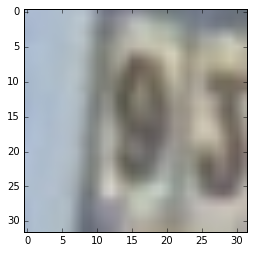

In [266]:
# Take a glance of data
plt.imshow(trainXs[6])

# Models